In [6]:
#%matplotlib widget
%matplotlib inline
import os, sys
dir_path = os.path.abspath("")
sys.path.append(dir_path)
from workshop_utils import *

# HPC Oriented Quantum Computing Simulation

## The Computational Challenge

As demonstrated in the benchmarking example, simulating quantum circuits presents a significant challenge due to the high computational costs. This is particularly evident in full state-vector simulations, where resource requirements grow exponentially, as shown in the figure below.

However, alternative approaches exist that can mitigate memory and computational demands, enabling more efficient simulations.

<Figure size 640x480 with 0 Axes>

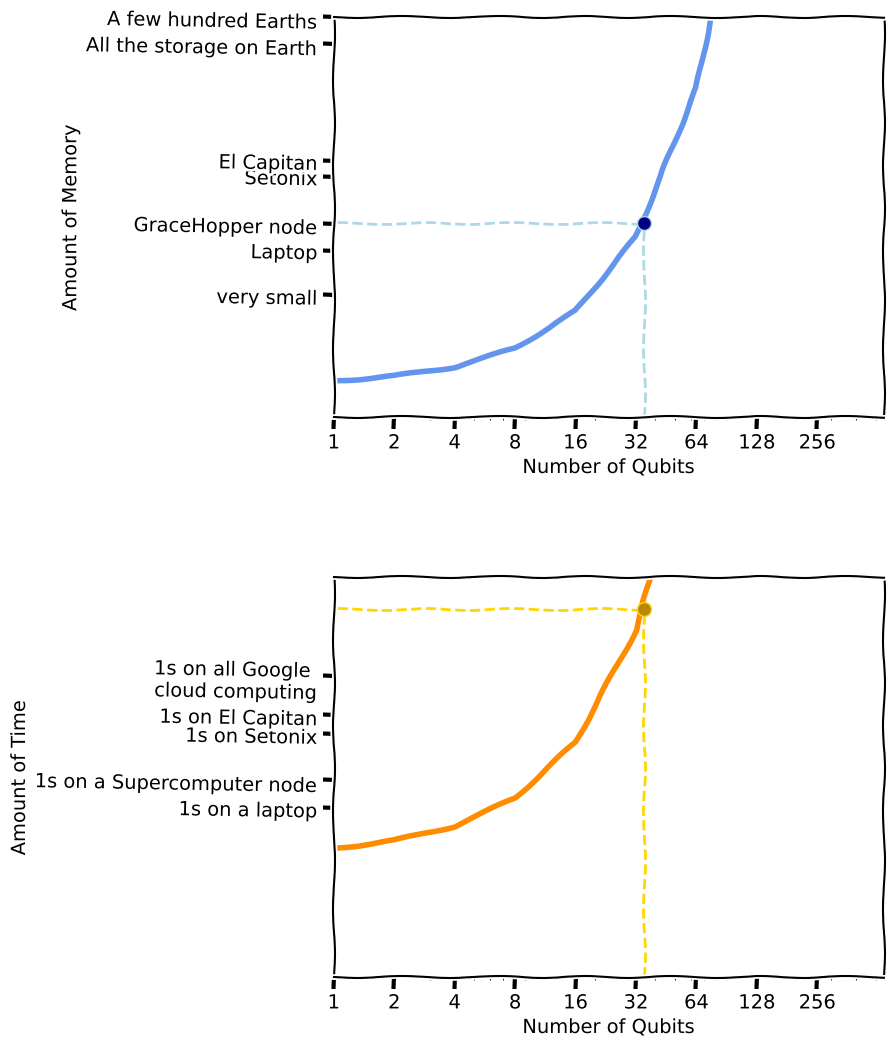

In [7]:
PlotSystemRequirements(num_qubits = 35, num_gates = 10000, num_measurements = 100)
plt.show()

## CUDAQ Grovers
In this section, we will explore scaling and computation using Grover’s algorithm by implementing it with CUDAQ. We will utilize the `C++` interface for this exercise. The base code can be found in the `grovers/src/` directory, and a `Makefile` is provided to compile the code with the necessary flags.

### Make a kernel 

The starting point is to define a kernel that specifies a `__qpu__` offloaded operator (check the language [specification](https://nvidia.github.io/cuda-quantum/latest/api/default_ops.html)). This kernel can accept multiple input arguments and will execute the quantum circuit defined within it using a backend—several backend options are available. The code structure will look something like this:


```c++
struct kernel
{
    auto operator()() __qpu__
    {
        // create the qubits 

        // initialize the state 

        // run the circuit 

        // measure 
        
        // and then add amplification 
    }
};

```

Next, we need to initialize the qubits, apply the appropriate quantum gates, and measure in a suitable basis to obtain meaningful results. Running the circuit can be as simple as including the following code:

```c++
auto result = cudaq::sample(num_shots, kernel{}, ...); // where we pass any arguments taken by the kernel as well 
```

## Example 
If you look at `grovers/src/grovers_cudaq.cpp`, you will find an example kernel:

```c++
struct kernel {
  auto operator()(const int n, const int namp) __qpu__ {

    auto qvector = cudaq::qvector(n);

    auto qcontrol = qvector.front(n - 1);
    auto &qtarget = qvector.back();

    // superposition
    cudaq::h(qvector);

    for (int i = 0; i < namp; i++) {
      // Mark state 010101...
      for (std::size_t k = 0; k < qvector.size(); k += 2) {
        cudaq::x(qvector[k]);
      }
      cudaq::z<cudaq::ctrl>(qcontrol, qtarget);
      for (std::size_t k = 0; k < qvector.size(); k += 2) {
        cudaq::x(qvector[k]);
      }

      // Diffusion Unitary
      cudaq::h(qvector);
      cudaq::x(qvector);
      cudaq::z<cudaq::ctrl>(qcontrol, qtarget);
      cudaq::x(qvector);
      cudaq::h(qvector);
    }
    cudaq::mz(qvector);
  }
};
```

We will use this source code as the foundation for exploring different backends and the Grover’s algorithm in general.

### Building example 

To build the code and a large number of backends, simply type `make` and this will build in `grovers/bin/`
```
grovers_cudaq_cpu_state_vec
grovers_cudaq_cpu_state_vec_fp64
grovers_cudaq_gpu_state_vec
grovers_cudaq_gpu_state_vec_fp64
grovers_cudaq_gpu_mps
grovers_cudaq_gpu_mps_fp64
```

### Running the code
The program accepts the following command-line parameters:

```bash
Usage : 
 -n <num_qubits [10] >
 -a <num_amplification [10] >
 -s <num_shots [100] >
 -i <num_iterations [1] >
 -d <depolarising_gate_probability [0] >
 -v visualise the circuit instead of simulating [0] >
```

Small qubit systems can be simulated efficiently, with execution times remaining relatively short. To explore performance variations, try running simulations with 10–20 qubits across different backends.

For example, you can execute a state-vector simulation using the CPU backend with 2 OpenMP threads by running the following command:

```bash
OMP_NUM_THREADS=2 ./grovers/bin/grovers_cudaq_cpu_state_vec
```

### Output 

An example of the output here will report the CPU binding and available GPUs, the memory available and the runtime variables.  

```
@main grovers_cudaq.cpp:L155 (Fri Feb 28 11:16:28 2025) :  Running Grovers
@main grovers_cudaq.cpp:L156 (Fri Feb 28 11:16:28 2025) : 
Parallel API's 
 ======== 
OpenMP version 202011 with total number of threads = 2 with total number of allowed levels 1
Using GPUs: Running with CUDA and found 1 devices

@main grovers_cudaq.cpp:L157 (Fri Feb 28 11:16:28 2025) : 
Core Binding 
 ======== 
         On node ella-n001.pawsey.org.au :  OMP Thread 0 :  at nested level 1 :  Core affinity = 0-69  
         On node ella-n001.pawsey.org.au :  OMP Thread 1 :  at nested level 1 :  Core affinity = 0-69  
         On node ella-n001.pawsey.org.au : GPU device 0 Device_Name=NVIDIA GH200 480GB Bus_ID=0009:01:00.0 Compute_Units=132 Max_Work_Group_Size=32 Local_Mem_Size=49152 Global_Mem_Size=102005473280

Memory report @ main L158 : Total : 565.236 [GiB]; Used  : 24.642 [GiB]; Free  : 333.339 [GiB]; Shared: 4.629 [GiB]; Cache : 216.087 [GiB]; Avail : 540.593 [GiB]; 
@main grovers_cudaq.cpp:L160 (Fri Feb 28 11:16:28 2025) : Grovers run with : num_qubits = 10 num_amplifaction = 10 num_shots = 100 depol_prob = 0 with timings and usage over 1
```

The code will then run the circuit a certain number of iterations (default is 1) and then report the time taken on host and device, CPU usage and GPU statistics over the compute.


```
@main grovers_cudaq.cpp:L184 (Fri Feb 28 11:16:28 2025) : Time taken between : @main grovers_cudaq.cpp:L184 - @main grovers_cudaq.cpp:L169 : 187 [ms]
@main grovers_cudaq.cpp:L186 (Fri Feb 28 11:16:28 2025) : Time taken on device between : @main grovers_cudaq.cpp:L186 - @main grovers_cudaq.cpp:L169 : 30 [ms]
@main grovers_cudaq.cpp:L188 (Fri Feb 28 11:16:28 2025) : CPU Usage (%) statistics taken between : @main grovers_cudaq.cpp:L188 - @main grovers_cudaq.cpp:L170 over 39 [ms] :  [ave,std,min,max] = [ 0, 0, 0, 0 ] 
@main grovers_cudaq.cpp:L189 (Fri Feb 28 11:16:28 2025) : Memory report @ main grovers_cudaq.cpp:L189 : VM current/peak: 13.635 [GiB] / 14.030 [GiB]; RSS current/peak: 181.531 [MiB] / 181.531 [MiB]
@main grovers_cudaq.cpp:L191 (Fri Feb 28 11:16:28 2025) : GPU Statistics || GPU0 Usage (%) statistics taken between : @main grovers_cudaq.cpp:L191 - @main grovers_cudaq.cpp:L170 over 39 [ms] :  [ave,std,min,max] = [ 0, 0, 0, 0 ]  || GPU0 Memory Usage (%) statistics taken between : @main grovers_cudaq.cpp:L191 - @main grovers_cudaq.cpp:L170 over 39 [ms] :  [ave,std,min,max] = [ 0, 0, 0, 0 ]  || GPU0 Power (%) statistics taken between : @main grovers_cudaq.cpp:L191 - @main grovers_cudaq.cpp:L170 over 39 [ms] :  [ave,std,min,max] = [ 98.81, 0, 98.81, 98.81 ]  GPU Energy (Wh) used = 0.000274472 || 
```

This is a good example of basically trivial amounts of compute needed for a 10 qubit state vector simulation, taking a total of 187 milliseconds 

#### Go bigger 
Let's try 19 qubits :

```
@main grovers_cudaq.cpp:L184 (Fri Feb 28 11:24:04 2025) : Time taken between : @main grovers_cudaq.cpp:L184 - @main grovers_cudaq.cpp:L169 : 39.511 [s]
@main grovers_cudaq.cpp:L186 (Fri Feb 28 11:24:04 2025) : Time taken on device between : @main grovers_cudaq.cpp:L186 - @main grovers_cudaq.cpp:L169 : 39.347 [s]
@main grovers_cudaq.cpp:L188 (Fri Feb 28 11:24:04 2025) : CPU Usage (%) statistics taken between : @main grovers_cudaq.cpp:L188 - @main grovers_cudaq.cpp:L170 over 39.379 [s] :  [ave,std,min,max] = [ 197.617, 0.553, 0.000, 287.000 ] 
@main grovers_cudaq.cpp:L189 (Fri Feb 28 11:24:04 2025) : Memory report @ main grovers_cudaq.cpp:L189 : VM current/peak: 13.645 [GiB] / 14.030 [GiB]; RSS current/peak: 187.363 [MiB] / 199.797 [MiB]
@main grovers_cudaq.cpp:L191 (Fri Feb 28 11:24:04 2025) : GPU Statistics || GPU0 Usage (%) statistics taken between : @main grovers_cudaq.cpp:L191 - @main grovers_cudaq.cpp:L170 over 39.379 [s] :  [ave,std,min,max] = [ 0.006, 0.002, 0.000, 1.000 ]  || GPU0 Memory Usage (%) statistics taken between : @main grovers_cudaq.cpp:L191 - @main grovers_cudaq.cpp:L170 over 39.379 [s] :  [ave,std,min,max] = [ 0.000, 0.000, 0.000, 0.000 ]  || GPU0 Power (%) statistics taken between : @main grovers_cudaq.cpp:L191 - @main grovers_cudaq.cpp:L170 over 39.379 [s] :  [ave,std,min,max] = [ 136.299, 0.100, 98.490, 137.040 ]  GPU Energy (Wh) used = 0.392996 || 
```

And try GPU 

```
@main grovers_cudaq.cpp:L184 (Fri Feb 28 11:26:14 2025) : Time taken between : @main grovers_cudaq.cpp:L184 - @main grovers_cudaq.cpp:L169 : 208 [ms]
@main grovers_cudaq.cpp:L186 (Fri Feb 28 11:26:14 2025) : Time taken on device between : @main grovers_cudaq.cpp:L186 - @main grovers_cudaq.cpp:L169 : 50 [ms]
@main grovers_cudaq.cpp:L188 (Fri Feb 28 11:26:14 2025) : CPU Usage (%) statistics taken between : @main grovers_cudaq.cpp:L188 - @main grovers_cudaq.cpp:L170 over 82 [ms] :  [ave,std,min,max] = [ 0, 0, 0, 0 ] 
@main grovers_cudaq.cpp:L189 (Fri Feb 28 11:26:14 2025) : Memory report @ main grovers_cudaq.cpp:L189 : VM current/peak: 14.270 [GiB] / 14.655 [GiB]; RSS current/peak: 308.020 [MiB] / 309.734 [MiB]
@main grovers_cudaq.cpp:L191 (Fri Feb 28 11:26:14 2025) : GPU Statistics || GPU0 Usage (%) statistics taken between : @main grovers_cudaq.cpp:L191 - @main grovers_cudaq.cpp:L170 over 82 [ms] :  [ave,std,min,max] = [ 2, 0, 2, 2 ]  || GPU0 Memory Usage (%) statistics taken between : @main grovers_cudaq.cpp:L191 - @main grovers_cudaq.cpp:L170 over 82 [ms] :  [ave,std,min,max] = [ 0, 0, 0, 0 ]  || GPU0 Power (%) statistics taken between : @main grovers_cudaq.cpp:L191 - @main grovers_cudaq.cpp:L170 over 82 [ms] :  [ave,std,min,max] = [ 99.66, 0, 99.66, 99.66 ]  GPU Energy (Wh) used = 0.000276833 || 
```

You can see that it took 39.5 seconds on the cpu but 50 mis on device and the device was barely used. 


## Let's Go!

In [3]:
! echo "Lets build"
! make clean
! make 

Lets build
rm -f grovers/bin/grovers_cudaq*
nvq++ -D_CUDA -L/opt/nvidia/hpc_sdk/Linux_aarch64/24.5/cuda/12.4/targets/sbsa-linux/lib/ -I/opt/nvidia/hpc_sdk/Linux_aarch64/24.5/cuda/12.4/targets/sbsa-linux/include/  -std=c++20 -O3 -Wall -Wextra -Wpedantic -fPIC -I/software/projects/pawsey0001/pelahi/SCA2025-AcceleratedQuantumSupercomputing_Tutorial/Pawsey/profile_util/include -Wl,-rpath,/software/projects/pawsey0001/pelahi/SCA2025-AcceleratedQuantumSupercomputing_Tutorial/Pawsey/profile_util/build/src -L/software/projects/pawsey0001/pelahi/SCA2025-AcceleratedQuantumSupercomputing_Tutorial/Pawsey/profile_util/build/src/  --target qpp-cpu --target-option fp32 grovers/src/grovers_cudaq.cpp -o grovers/bin/grovers_cudaq_cpu_state_vec -lcudart -lprofile_util
rm -f grovers_cudaq.o
nvq++ -D_CUDA -L/opt/nvidia/hpc_sdk/Linux_aarch64/24.5/cuda/12.4/targets/sbsa-linux/lib/ -I/opt/nvidia/hpc_sdk/Linux_aarch64/24.5/cuda/12.4/targets/sbsa-linux/include/  -std=c++20 -O3 -Wall -Wextra -Wpedantic -fPIC -I/

In [4]:
! echo "Let's draw the circuit with only 1 amplification"
! nqubits=(10 15 20); for i in ${nqubits[@]}; do echo "Drawing ${i} qubit circuit"; grovers/bin/grovers_cudaq_cpu_state_vec -n ${i} -a 1 -v; done

Let's draw the circuit with only 1 amplification
Drawing 10 qubit circuit
Gate Count : 62
     ╭───╮╭───╮     ╭───╮╭───╮╭───╮     ╭───╮╭───╮
q0 : ┤ h ├┤ x ├──●──┤ x ├┤ h ├┤ x ├──●──┤ x ├┤ h ├
     ├───┤╰───╯  │  ├───┤├───┤╰───╯  │  ├───┤├───┤
q1 : ┤ h ├───────●──┤ h ├┤ x ├───────●──┤ x ├┤ h ├
     ├───┤╭───╮  │  ├───┤├───┤╭───╮  │  ├───┤├───┤
q2 : ┤ h ├┤ x ├──●──┤ x ├┤ h ├┤ x ├──●──┤ x ├┤ h ├
     ├───┤╰───╯  │  ├───┤├───┤╰───╯  │  ├───┤├───┤
q3 : ┤ h ├───────●──┤ h ├┤ x ├───────●──┤ x ├┤ h ├
     ├───┤╭───╮  │  ├───┤├───┤╭───╮  │  ├───┤├───┤
q4 : ┤ h ├┤ x ├──●──┤ x ├┤ h ├┤ x ├──●──┤ x ├┤ h ├
     ├───┤╰───╯  │  ├───┤├───┤╰───╯  │  ├───┤├───┤
q5 : ┤ h ├───────●──┤ h ├┤ x ├───────●──┤ x ├┤ h ├
     ├───┤╭───╮  │  ├───┤├───┤╭───╮  │  ├───┤├───┤
q6 : ┤ h ├┤ x ├──●──┤ x ├┤ h ├┤ x ├──●──┤ x ├┤ h ├
     ├───┤╰───╯  │  ├───┤├───┤╰───╯  │  ├───┤├───┤
q7 : ┤ h ├───────●──┤ h ├┤ x ├───────●──┤ x ├┤ h ├
     ├───┤╭───╮  │  ├───┤├───┤╭───╮  │  ├───┤├───┤
q8 : ┤ h ├┤ x ├──●──┤ x ├┤ h ├┤ x ├──●──┤ x

In [8]:
# Let's run all the different backends but with no noise
backends=['cpu_state_vec', 'cpu_state_vec_fp64', 'gpu_state_vec', 'gpu_state_vec_fp64', 'gpu_mps', 'gpu_mps_fp64']
nqubits = {
    'cpu_state_vec': [10, 15, 20],
    'cpu_state_vec_fp64': [10, 15, 20],
    'gpu_state_vec': [10, 15, 20, 25, 30],
    'gpu_state_vec_fp64': [10, 15, 20, 25, 30],
    'gpu_mps': [10, 15, 20, 25, 30],
    'gpu_mps_fp64' : [10, 15, 20, 25, 30],
}
profdata = dict()
output = dict()

my_env = os.environ.copy()
my_env["OMP_NUM_THREADS"] = "32"
rerun = False
n = '0.0'
display(Markdown(f'#### Starting Ideal Grover algorithm'))
for b in backends:
    profdata[b] = {q: dict() for q in nqubits[b]}
    output[b] = {q: dict() for q in nqubits[b]}
    for q in nqubits[b]: 
        output[b][q] = {n: None}
        output[b][q][n], logname = RunGrovers(b = b, q  = q, n = n, rerun = rerun, my_env = my_env)
        print(f'Loading {b}, Qubit {q}, Noise {n}')
        profdata[b][q][n] = ParseProfilingOutput(logname)
display(Markdown(f'#### Finished'))


#### Starting Ideal Grover algorithm

Loading cpu_state_vec, Qubit 10, Noise 0.0
Loading cpu_state_vec, Qubit 15, Noise 0.0
Loading cpu_state_vec, Qubit 20, Noise 0.0
Loading cpu_state_vec_fp64, Qubit 10, Noise 0.0
Loading cpu_state_vec_fp64, Qubit 15, Noise 0.0
Loading cpu_state_vec_fp64, Qubit 20, Noise 0.0
Loading gpu_state_vec, Qubit 10, Noise 0.0
Loading gpu_state_vec, Qubit 15, Noise 0.0
Loading gpu_state_vec, Qubit 20, Noise 0.0
Loading gpu_state_vec, Qubit 25, Noise 0.0
Loading gpu_state_vec, Qubit 30, Noise 0.0
Loading gpu_state_vec_fp64, Qubit 10, Noise 0.0
Loading gpu_state_vec_fp64, Qubit 15, Noise 0.0
Loading gpu_state_vec_fp64, Qubit 20, Noise 0.0
Loading gpu_state_vec_fp64, Qubit 25, Noise 0.0
Loading gpu_state_vec_fp64, Qubit 30, Noise 0.0
Loading gpu_mps, Qubit 10, Noise 0.0
Loading gpu_mps, Qubit 15, Noise 0.0
Loading gpu_mps, Qubit 20, Noise 0.0
Loading gpu_mps, Qubit 25, Noise 0.0
Loading gpu_mps, Qubit 30, Noise 0.0
Loading gpu_mps_fp64, Qubit 10, Noise 0.0
Loading gpu_mps_fp64, Qubit 15, Noise 0.0
Loa

#### Finished

## Results

Let's look at the results. Note that our kernel marks the 01 repeating state so for 10 qubits, we should see that the state 0101010101 is significantly more probably that all the other states. 

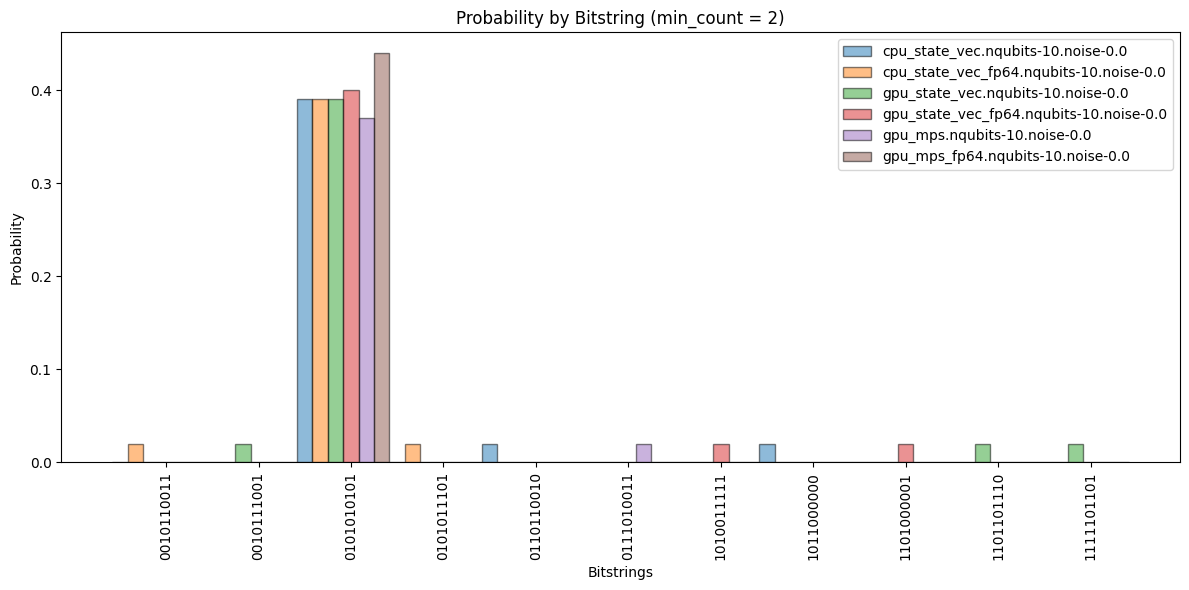

In [9]:
# Let's examine the results. 
# Recall Marked state is '01' repeating. 
# number of qubits and noise (here ideal)
q = 10
n = '0.0'
visualise_bitstring_counts([output[b][q][n] for b in backends], min_count = 2)

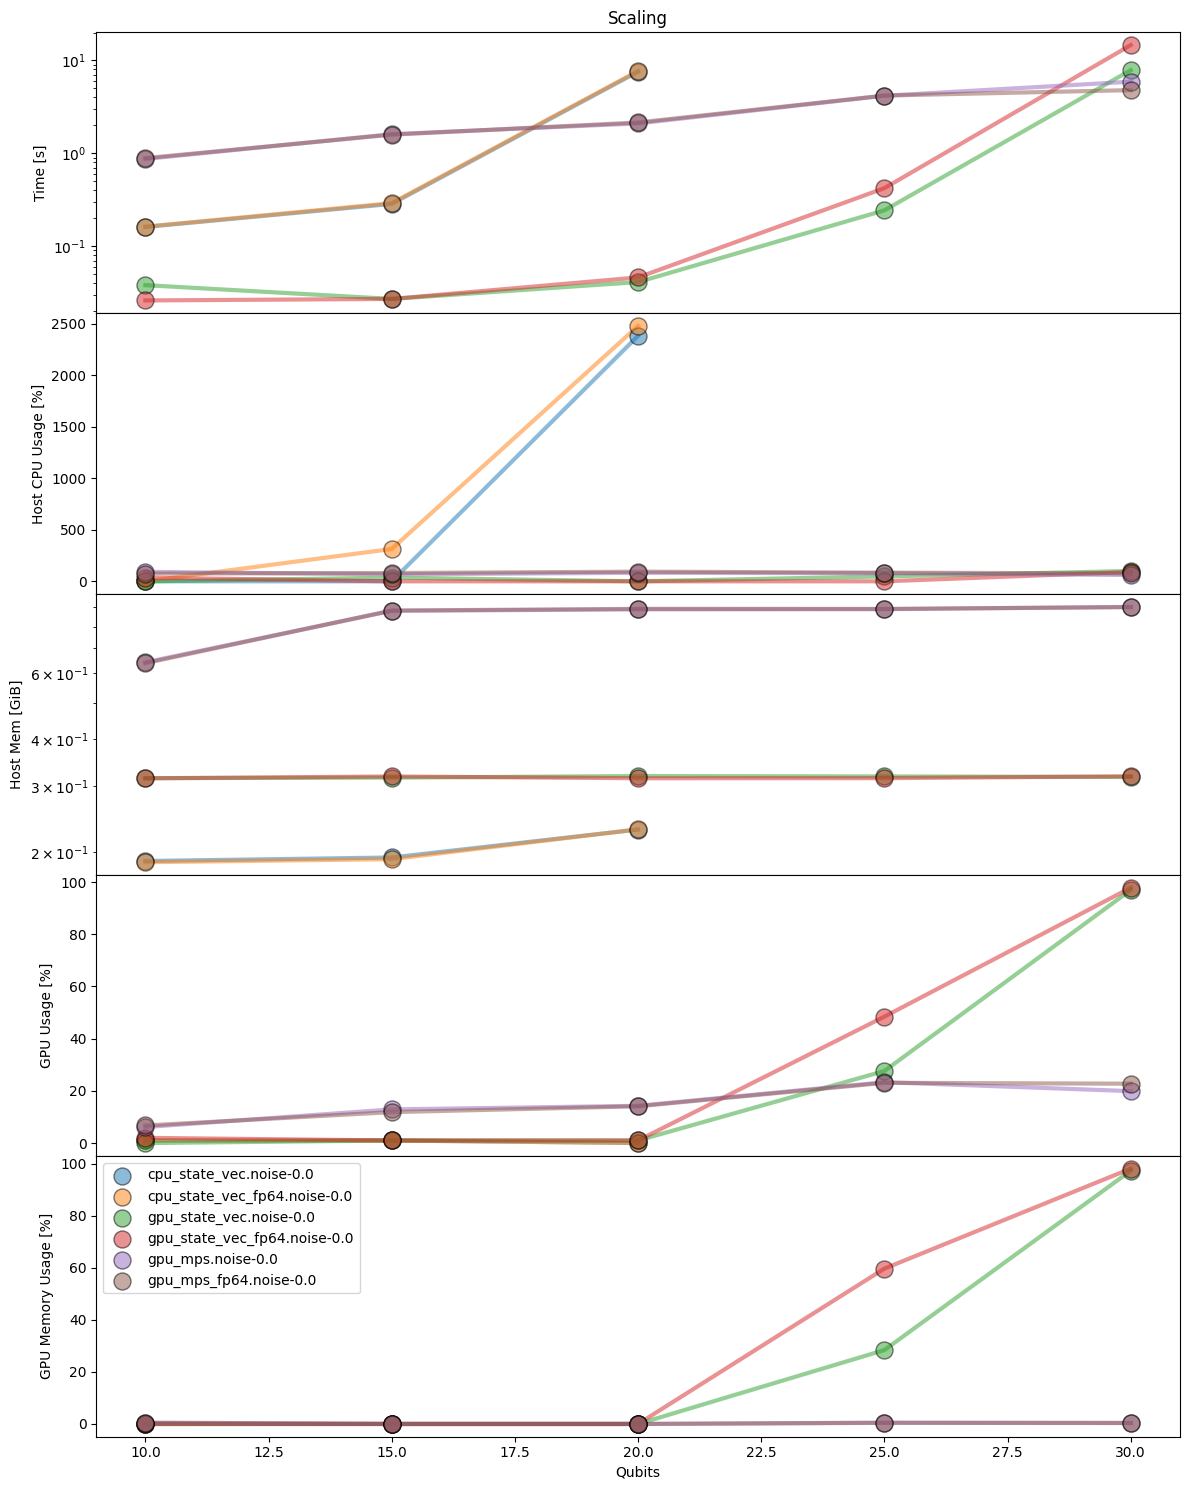

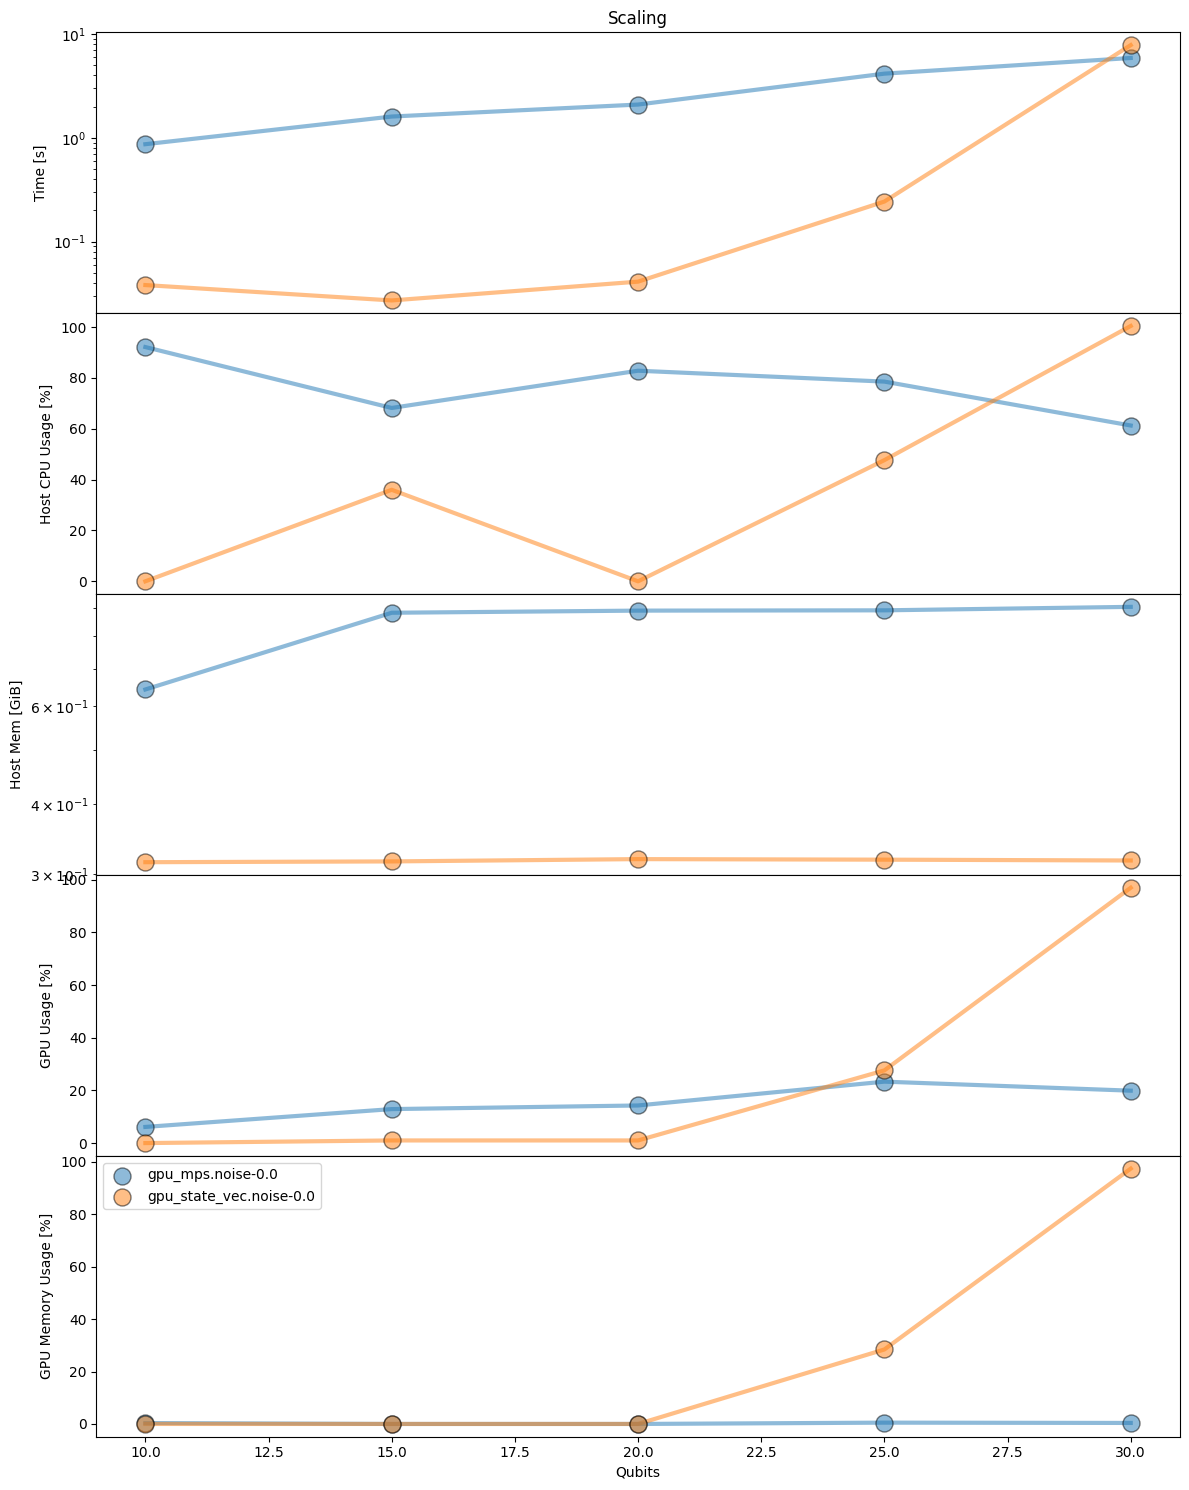

In [10]:
# lets look at the profiling for all the noiseless runs to start
visualise_profiling_ideal(profdata)

# then lets look at the scaling of two gpu runs but focus on full state vector versus matrix-product-state 
visualise_profiling_ideal(profdata, backends = ['gpu_mps', 'gpu_state_vec'])

# Try just comparing results. Let's look at comparing cpu and gpu state vec simulation
# CompareResults(profdata, b1 = 'cpu_state_vec', b2 = 'gpu_state_vec')


## Noisy Intermediate-Scale Quantum (NISQ) Era 

Currently, most quantum processing units (QPUs) operate as **Noisy Intermediate-Scale Quantum (NISQ)** devices. Simulating these noisy devices presents a significant challenge because it often requires a **full density-matrix representation** (even Monte Carlo method is also frequently been employed), which scales as $\mathcal{O}(2^{2n})$. In contrast, simulating an ideal state-vector representation is computationally more efficient, scaling as $\mathcal{O}(2^n)$. This exponential overhead makes noise simulation considerably more demanding, especially for larger qubit counts.

### Depolarising Noise

Depolarizing noise is a quantum error model that describes the loss of coherence and information due to interactions with the environment, effectively driving the system toward a maximally mixed state. It is characterized by a probability $ p $ of an error occurring. In a single-qubit depolarizing channel, one of the Pauli operators $ X $, $ Y $, or $ Z $ is applied with equal probability $ p/3 $, while the qubit remains unchanged with probability $ 1 - p $.

In quantum circuit simulations, depolarizing noise is typically introduced:
* after each gate operation to account for noisy gate operations, or
* at fixed time intervals to account for the accumulation of decoherence.

This noise model is widely used in quantum error correction and benchmarking as it provides a realistic yet analytically and computationally manageable approximation of real-world quantum noise processes.

For depolarisation noise we can construct new kind of gates: 
```c++
// Generalized noisy gate template
template <void (*Gate)(cudaq::qubit &)>
__qpu__ void noisy_gate(cudaq::qview<> qubit, float depol_prob, float p1,
                        float p2) {

  Gate(qubit[0]); // Apply the main gate (X, Y, or Z)

  if (depol_prob > p1) { // Apply depolarizing noise conditionally
    int idx = static_cast<int>(p2 * 3) % 3;
    pauli_ops[idx](qubit[0]); // Apply random depolarizing noise
  }
}

// Define specific noisy versions of X, Y, and Z gates
__qpu__ void noisy_x(cudaq::qview<> qubit, float depol_prob, float p1,
                     float p2) {
  noisy_gate<cudaq::x>(qubit, depol_prob, p1, p2);
}

__qpu__ void noisy_y(cudaq::qview<> qubit, float depol_prob, float p1,
                     float p2) {
  noisy_gate<cudaq::y>(qubit, depol_prob, p1, p2);
}

__qpu__ void noisy_z(cudaq::qview<> qubit, float depol_prob, float p1,
                     float p2) {
  noisy_gate<cudaq::z>(qubit, depol_prob, p1, p2);
}

__qpu__ void noisy_h(cudaq::qview<> qubit, float depol_prob, float p1,
                     float p2) {
  noisy_gate<cudaq::h>(qubit, depol_prob, p1, p2);
}

// Apply depolarizing noise without a preceding gate
// This would be representative of decoherence rather than a noisy gate operation
__qpu__ void depol_noise(cudaq::qview<> qubit, float depol_prob, float p1,
                         float p2) {
  if (depol_prob > p1) {
    int idx = static_cast<int>(p2 * 3) % 3;
    pauli_ops[idx](qubit[0]); // Apply random depolarizing noise
  }
}
```

### Noisy circuits

First let's explore the impact of this type of noise model visually. You will see below that the number of gates has increased for a simulation with large amounts of noise, here $p=0.5$. 

In [11]:
! echo "Let's draw the circuit with only 1 amplification but add Noise!"
! noise=0.5; nqubits=(10 15 20); for i in ${nqubits[@]}; do echo "Drawing ${i} qubit circuit"; grovers/bin/grovers_cudaq_cpu_state_vec -n ${i} -d ${noise} -a 1 -v; done

Let's draw the circuit with only 1 amplification but add Noise!
Drawing 10 qubit circuit
Gate Count : 106
     ╭───╮╭───╮╭───╮╭───╮     ╭───╮╭───╮╭───╮╭───╮╭───╮               ╭───╮»
q0 : ┤ h ├┤ x ├┤ x ├┤ x ├──●──┤ x ├┤ x ├┤ h ├┤ z ├┤ x ├────────────●──┤ x ├»
     ├───┤╰───╯╰───╯╰───╯  │  ├───┤├───┤├───┤╰───╯╰───╯            │  ├───┤»
q1 : ┤ h ├─────────────────●──┤ h ├┤ x ├┤ x ├──────────────────────●──┤ x ├»
     ├───┤╭───╮╭───╮       │  ├───┤├───┤├───┤╭───╮╭───╮╭───╮╭───╮  │  ├───┤»
q2 : ┤ h ├┤ x ├┤ y ├───────●──┤ z ├┤ x ├┤ z ├┤ h ├┤ z ├┤ x ├┤ z ├──●──┤ z ├»
     ├───┤├───┤╰───╯       │  ├───┤├───┤├───┤╰───╯╰───╯╰───╯╰───╯  │  ├───┤»
q3 : ┤ h ├┤ y ├────────────●──┤ h ├┤ x ├┤ y ├──────────────────────●──┤ y ├»
     ├───┤├───┤╭───╮       │  ├───┤├───┤├───┤╭───╮╭───╮            │  ├───┤»
q4 : ┤ h ├┤ x ├┤ y ├───────●──┤ x ├┤ x ├┤ h ├┤ x ├┤ x ├────────────●──┤ x ├»
     ├───┤╰───╯╰───╯       │  ├───┤├───┤├───┤├───┤╰───╯            │  ├───┤»
q5 : ┤ h ├─────────────────●──┤ x ├┤ h ├┤ y ├┤ 

### Noisy results

Now let's try running a few different values of noise. We won't run with very large noises (that choise was more to emphasize the impact on the circuit). Smaller values of noise might not seem to have much impact with a circuit but small changes in the circuit can drastically impact the performance of the Grover diffusion operator. 

In [13]:
# Now try with noise! 
noises = ['0.001', '0.01', '0.05', '0.1']
# run certain number of trajectories 
nt = 10
rerun = False
for b in backends:
    for q in nqubits[b]: 
        for n in noises:
            output[b][q][n], logname = RunGrovers(b = b, q  = q, n = n, nt = nt, rerun = rerun, my_env = my_env)
            print(f'Loading {b}, Qubit {q}, Noise {n}')
            profdata[b][q][n] = ParseProfilingOutput(logname)


Loading cpu_state_vec, Qubit 10, Noise 0.001
Loading cpu_state_vec, Qubit 10, Noise 0.01
Loading cpu_state_vec, Qubit 10, Noise 0.05
Loading cpu_state_vec, Qubit 10, Noise 0.1
Loading cpu_state_vec, Qubit 15, Noise 0.001
Loading cpu_state_vec, Qubit 15, Noise 0.01
Loading cpu_state_vec, Qubit 15, Noise 0.05
Loading cpu_state_vec, Qubit 15, Noise 0.1
Loading cpu_state_vec, Qubit 20, Noise 0.001
Loading cpu_state_vec, Qubit 20, Noise 0.01
Loading cpu_state_vec, Qubit 20, Noise 0.05
Loading cpu_state_vec, Qubit 20, Noise 0.1
Loading cpu_state_vec_fp64, Qubit 10, Noise 0.001
Loading cpu_state_vec_fp64, Qubit 10, Noise 0.01
Loading cpu_state_vec_fp64, Qubit 10, Noise 0.05
Loading cpu_state_vec_fp64, Qubit 10, Noise 0.1
Loading cpu_state_vec_fp64, Qubit 15, Noise 0.001
Loading cpu_state_vec_fp64, Qubit 15, Noise 0.01
Loading cpu_state_vec_fp64, Qubit 15, Noise 0.05
Loading cpu_state_vec_fp64, Qubit 15, Noise 0.1
Loading cpu_state_vec_fp64, Qubit 20, Noise 0.001
Loading cpu_state_vec_fp64, Qu

### Noisy Grover's 
If we now plot the results, we can see how much worse the quantum circuit is at amplifying the desired state. 

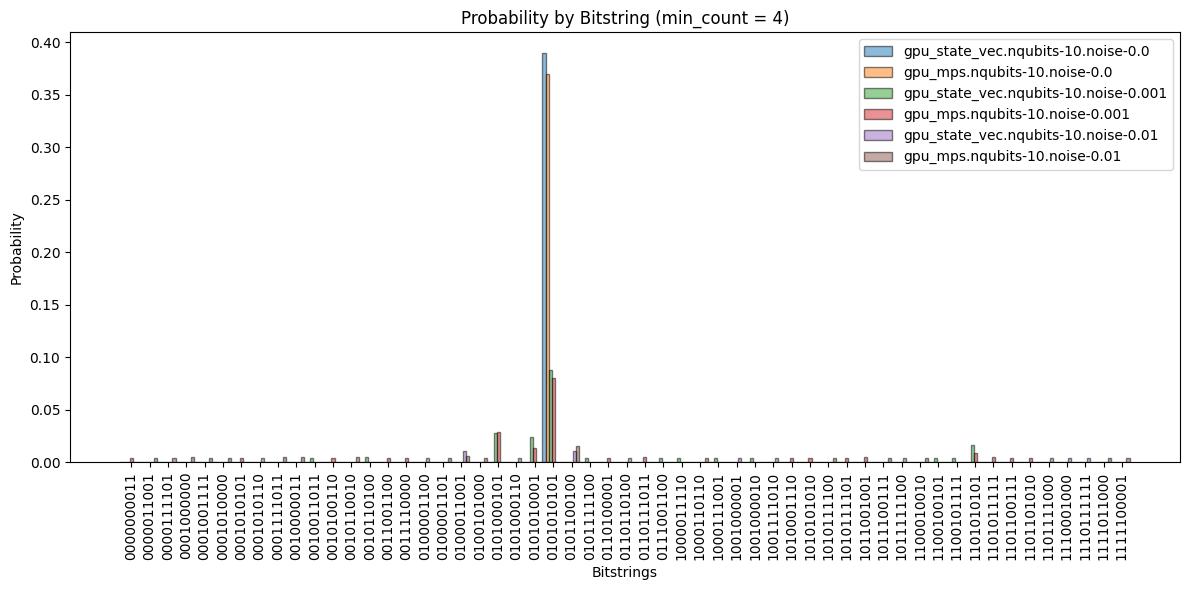

In [14]:
# Let's examine the results, just looking at few backends but with the addition of noise 
# Recall Marked state is '01' repeating. 
# number of qubits and noise (here ideal)
bs = ['gpu_state_vec', 'gpu_mps']
q = 10
n = '0.0'
data = [output[b][q][n] for b in bs]
n = '0.001'
data = data + [output[b][q][n] for b in bs]
n = '0.01'
data = data + [output[b][q][n] for b in bs]
visualise_bitstring_counts(data, min_count = 4)

### Noisy simulation

We can also compare the impact running more realistic quantum circuits that try to account for quantum computing device noise on the simulation runtime of a quantum circuit. 

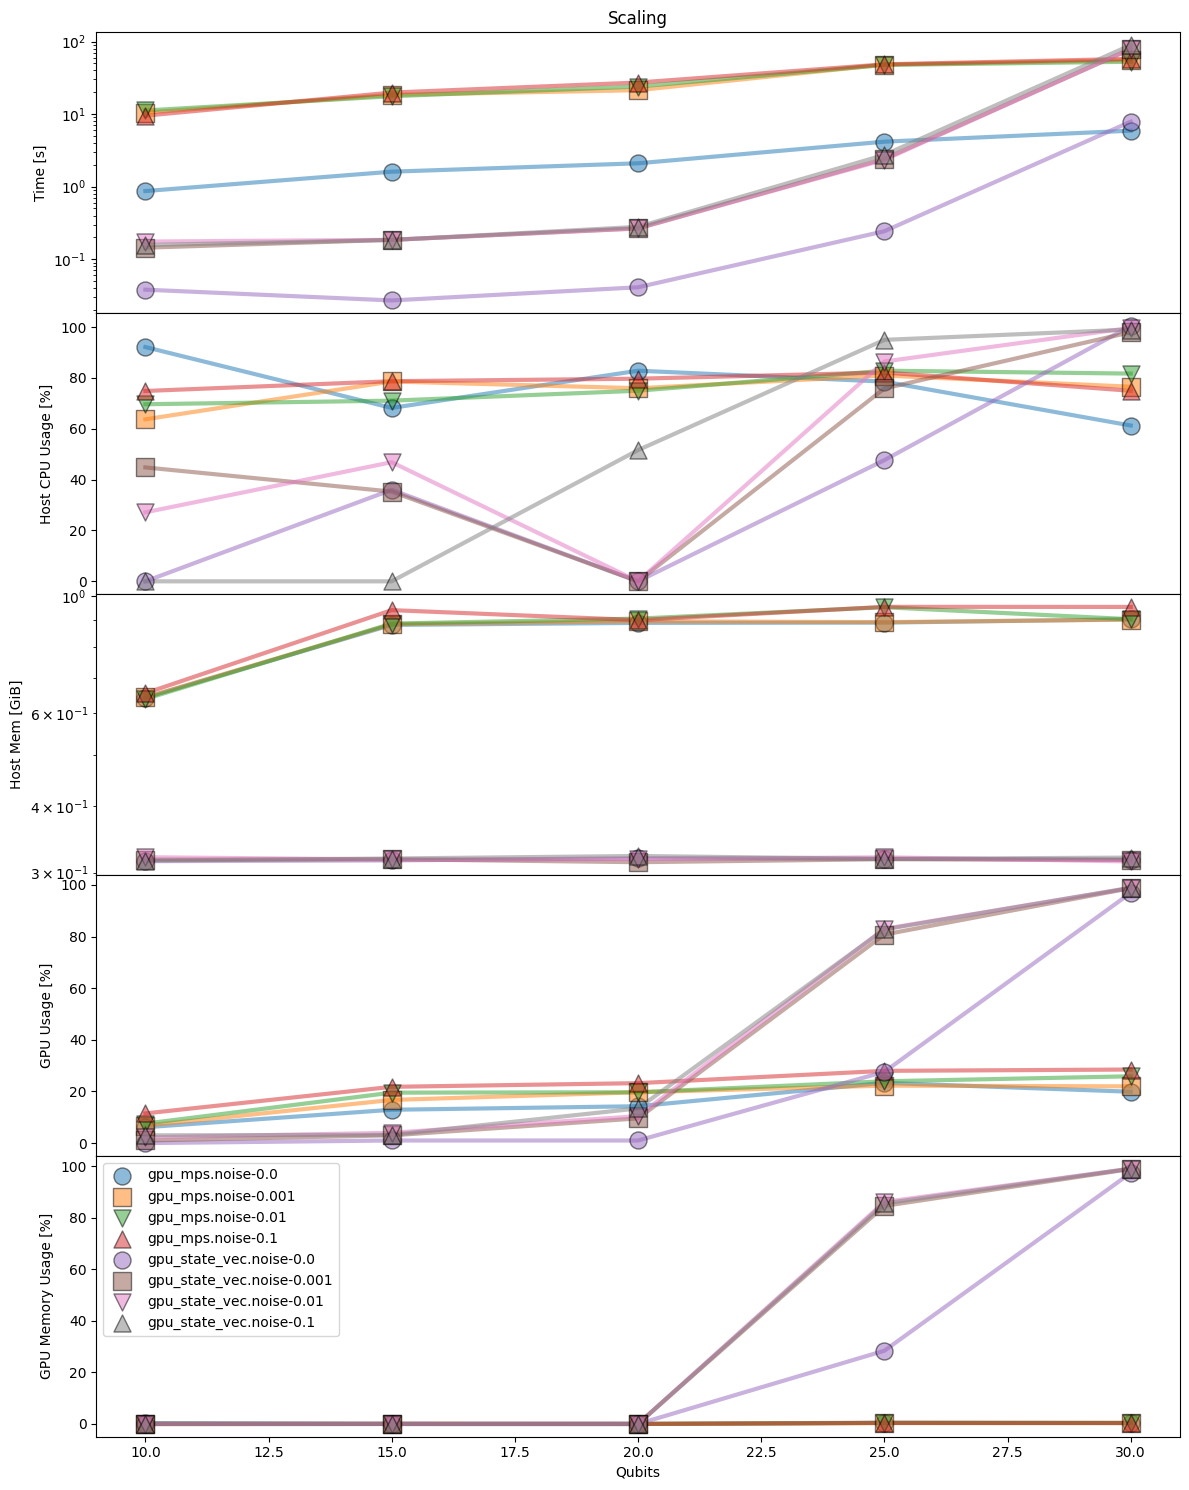

In [15]:
# lets compare noise to no noise 
#CompareToNoiseResults(profdata, 'cpu_state_vec', nqubits = [10])
visualise_profiling_ideal(profdata, backends = ['gpu_mps', 'gpu_state_vec'], noises=['0.0', '0.001', '0.01', '0.1'])


## HPC Quantum Simulation Challenge

The impact of noise, the need to explore noisy simulations to test error correction techniques, the impact noise might have on an uncorrect quantum algorithm is where the HPC challenge lies. Pushing to every higher noisy qubit counts to identif